In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import json
import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

from tqdm import tqdm
import pyproj  

from geopandas.tools import sjoin

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [49]:
def checkinPreprocessing(checkins):
    #date and time processing

    #create date-time feature
    dateTime = checkins['datetime']
    dateTime.head()

    #split into date and time column 
    #year format: YYYY-MM-DD 
    #time format: HH:MM:SS

    hourOfCheckin = list()
    dayOfCheckin = list()
    weekdayOrWeekendCheckin = list()
    dateList = list()
    timeList = list()

    for index in range(0, dateTime.shape[0]):
        
        #convert date to date object
        date = dateTime[index][:dateTime[index].find("T")] #extract date from datetime string 
        year = int(date[:date.find("-")])
        month = int(date[date.find("-")+1:date.rfind("-")])
        day = int(date[date.rfind("-")+1:])
        date = datetime.date(year, month, day) #create a date object
        dateList.append(date)
        #convert time to time object
        time = dateTime[index][dateTime[index].find("T")+1:-1] #extract time as string 
        hour = int(time[:time.find(":")])
        minute = int(time[time.find(":")+1:time.rfind(":")])
        second = int(time[time.rfind(":")+1:])
        time = datetime.time(hour=hour, minute=minute, second=second)
        timeList.append(time)
        
        #from date object extract day of the week
        day = date.weekday() #integer representation of day of the week - 0 is Monday and 6 is Sunday
        dayOfCheckin.append(day)
        
        #hour of checkin - one hot encode this feature as 24 slots  
        hourOfCheckin.append(hour)
        
        #weekday or weekend - FEATURE
        if day == 5 or day == 6: #saturday or sunday 
            weekdayOrWeekendCheckin.append(1) #weekened checkin
        else:
            weekdayOrWeekendCheckin.append(0) #weekday checkin

    #add dates and times to the dataframe
    checkins['Date'] = dateList
    checkins['Time'] = timeList
    checkins['WeekdayOrWeekend'] = weekdayOrWeekendCheckin #add weekday or weekend field

    checkins.drop("datetime", axis=1, inplace=True)

    return checkins, dateList

def locationPreprocessing(placesDf):

    #extract the location information 
    locationInformation = list()
    for rowIndex in placesDf.index:
        
        rowInstance = placesDf['spot_categories'][rowIndex]
        firstIndex = rowInstance.rfind(":") + 3
        secondIndex = rowInstance.rfind("'")
        
        if len(locationInformation) == 0:
            locationInformation = [rowInstance[firstIndex:secondIndex].strip()]
        else:
            locationInformation.append(rowInstance[firstIndex:secondIndex].strip())
            
    #dataframe created for checking purposes
    placesDf['Locations'] = pd.DataFrame(locationInformation, columns=['Locations'])

    #use locationDf and the read in location category relationship df
    locationCategoryDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/LocationCategoryRelationshipsData.csv", usecols=['Specific Category', 'Main Category'])

    #connect the locationDf and the location category relationship df to align the POI categories with the locations
    placesDf = placesDf.join(locationCategoryDf.set_index('Specific Category'), on='Locations')

    #drop any unecessary columns
    placesDf.drop("created_at", axis=1, inplace=True)
    placesDf.drop("spot_categories", axis=1, inplace=True)

    placesDf.index = range(0, placesDf.shape[0]) #reindex so join is succesful
    
    return placesDf


#occurs after spatial processing
def userProcessing():

    checkinsDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv")
    nzCheckins = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckinsWithGridTokens.csv")
    userDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_userinfo.csv")
    
    #join checkins df and nz checkins to only extract NZ checkins 
    checkinsDf['id'] = checkinsDf.index #create id field
    nzCheckins.drop("lat", axis=1, inplace=True) #drop lat so no error
    nzCheckins.drop("lng", axis=1, inplace=True) #drop lng so no error
    checkinsDf = nzCheckins.join(checkinsDf.set_index('id'), on='id')
    checkinsDf.drop("Unnamed: 0", axis=1, inplace=True)
    
    #user category calculation 
    userPreferenceDf = userCategoryPreference(checkinsDf)
    
    #join userDf to userPreferenceDf
    userDf = userPreferenceDf.join(userDf.set_index('id'), on='userid')
    #drop any NaN columns
    userDf.dropna(inplace=True)
    
    #join userDf to the checkinsDf
    checkinsDf = checkinsDf.join(userDf.set_index('userid'), on='userid', rsuffix='_user', lsuffix='_places')
    checkinsDf.dropna(inplace=True)
    
    return checkinsDf
    
    

def userCategoryPreference(checkinsDf):
    
    userPreferenceDf = pd.DataFrame([])
    users = np.unique(checkinsDf['userid']) #list of user id's

    lbE = LabelEncoder()
    labelEncodedPOICategories = lbE.fit_transform(checkinsDf['Main Category'])

    #calculate user category preference metric 
    for user in users:

        #checkins subset by users
        poiCount = np.repeat(0, repeats=7)
        userCheckins = labelEncodedPOICategories[checkinsDf[checkinsDf['userid'] == user].index]
        poi, counts = np.unique(userCheckins, return_counts=True)
        #assign counts to poiCount and place in correct index - index corresponds to poi cat integer label
        for index in range(0, poi.shape[0]):
            poiCount[poi[index]] = counts[index] 

        userPreferenceDf = pd.concat([userPreferenceDf,pd.DataFrame(poiCount).T], axis=0)

    #add category preference POI column names
    userPreferenceDf.columns = list(lbE.classes_)    
    userPreferenceDf['userid'] = users #add a userid column as a primary key
    
    return userPreferenceDf

### Main Code

#### Locations

In [3]:
#LOCATIONS
placesDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_spots_subset1.csv")
print("Locations Loaded")
placesDf = locationPreprocessing(placesDf)
placesDf.dropna(inplace=True) #drop any NaN rows 
print("Locations Processed")

Locations Loaded
Locations Processed


#### Basic Checkin Processing 
Join checkins and location information together in chunks

In [4]:
chunksize = 10 ** 6
firstIteration = True
index = 0

for chunk in pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_checkins.csv", chunksize=chunksize):
    #each chunk is 1 million rows
    
    print("Start Iteration ", str(index))
    
    #drop any rows with NaN 
    chunk.dropna(inplace=True)
    
    #checkin process chunk
    chunk.index = range(0,chunk.shape[0])
    checkins,dateList = checkinPreprocessing(chunk)
    
    #Join the locationDf and the checkinsDf
    checkins = checkins.join(placesDf.set_index('id'), on='placeid')
    #drop any NaN rows
    checkins.dropna(inplace=True)
    
    #write out prior to aligning 
    if firstIteration:
        checkins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv", header=True, index=False)
        firstIteration = False
    else:
        checkins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv",  mode='a', header=False, index=False)
        
    print("Finished Iteration ", str(index))
    print()
    index += 1 
    

Start Iteration  0
(1000016, 16)
(994419, 16)
Finished Iteration  0

Start Iteration  1
(1000014, 16)
(996310, 16)
Finished Iteration  1

Start Iteration  2
(1000019, 16)
(994168, 16)
Finished Iteration  2

Start Iteration  3
(1000005, 16)
(992954, 16)
Finished Iteration  3

Start Iteration  4
(1000018, 16)
(993602, 16)
Finished Iteration  4

Start Iteration  5
(1000021, 16)
(987723, 16)
Finished Iteration  5

Start Iteration  6
(1000009, 16)
(990971, 16)
Finished Iteration  6

Start Iteration  7
(1000017, 16)
(992777, 16)
Finished Iteration  7

Start Iteration  8
(1000005, 16)
(992208, 16)
Finished Iteration  8

Start Iteration  9
(1000017, 16)
(990356, 16)
Finished Iteration  9

Start Iteration  10
(1000008, 16)
(991509, 16)
Finished Iteration  10

Start Iteration  11
(1000008, 16)
(989840, 16)
Finished Iteration  11

Start Iteration  12
(1000011, 16)
(985674, 16)
Finished Iteration  12

Start Iteration  13
(1000014, 16)
(990806, 16)
Finished Iteration  13

Start Iteration  14
(10000

### Geospatial Mapping

In [5]:
#DONT RUN
checkins = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv")
#save geospatial mapping points
checkins[["lng", "lat"]].to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/checkinsGeospatialMarkers.csv")

In [9]:
#read in geospatial mapping file 
df = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/checkinsGeospatialMarkers.csv")
df.columns = ['id', 'lng', 'lat'] #field rename

In [10]:
#read world shape file
worldMap = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

In [11]:
nzMap = worldMap[worldMap['name'] == "New Zealand"]
#latitude = vertical
#longitude = horizontal

In [12]:
#DONT RUN as saved nz checkins
#subset to NZ checkins
lngMin,latMin,lngMax,latMax = nzMap.total_bounds
lngMask = np.logical_and(df['lng'] >= lngMin,df['lng'] <= lngMax)
latMask = np.logical_and(df['lat'] >= latMin,df['lat'] <= latMax)
nzMask = np.logical_and(lngMask,latMask)
nzCheckins = df[nzMask]
nzCheckins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckinsGeospatialMarkers.csv", index=False)

In [13]:
#read in nz checkin data
nzCheckins = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckinsGeospatialMarkers.csv")

In [14]:
geometry = [Point(xy) for xy in zip(nzCheckins['lng'], nzCheckins['lat'])]
crs = {'init': "+init=epsg:4326"} #co ordinate frame reference

In [15]:
#create a geo-dataframe
geoDf = gpd.GeoDataFrame(nzCheckins,
                        crs=crs, 
                        geometry=geometry)
geoDf

,id,lng,lat,geometry
0,1510,175.302670,-37.805193,POINT (175.30267 -37.80519)
1,25458,174.783146,-37.005414,POINT (174.78315 -37.00541)
2,25459,174.005198,-41.285401,POINT (174.00520 -41.28540)
3,25460,170.966727,-42.719118,POINT (170.96673 -42.71912)
4,25461,174.781725,-41.293435,POINT (174.78172 -41.29343)
...,...,...,...,...
20190,35659960,174.763893,-36.852802,POINT (174.76389 -36.85280)
20191,35673903,168.656087,-45.028518,POINT (168.65609 -45.02852)
20192,35673904,169.161902,-44.696964,POINT (169.16190 -44.69696)
20193,35673905,170.182921,-43.384175,POINT (170.18292 -43.38417)


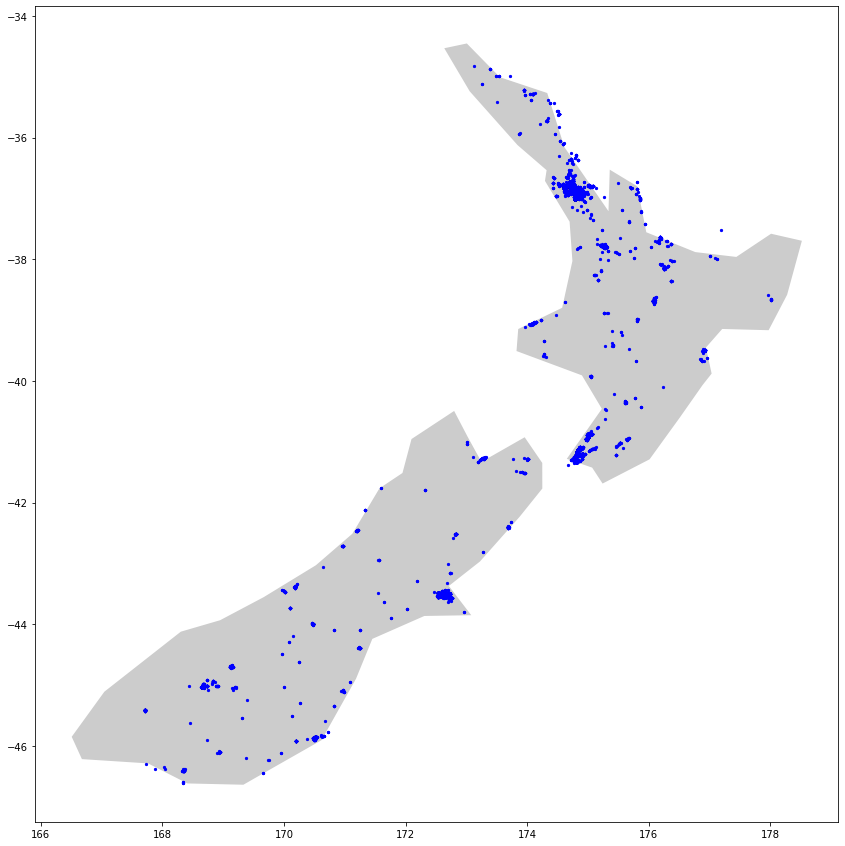

In [16]:
#plot checkins
fig, ax = plt.subplots(figsize=(15,15))
nzMap.plot(ax=ax,alpha=0.4,color="grey")
geoDf.plot(ax=ax, markersize=5, color="blue", marker="o")

In [20]:
#create polygons and index them - create grid
#check if point is inside grid and label points inside each grid square

#reproject points to crs that uses metres
geoDf.drop("geometry", axis=1)
geodf = gpd.GeoDataFrame(geoDf)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+init=epsg:27200")

# Reproject map crs to one that uses metres 
nzMap = nzMap.to_crs('+init=epsg:27200')
xmin,ymin,xmax,ymax = nzMap.total_bounds

length = 10 ** 3
wide = 10 ** 3

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

gridIndexSeries = pd.Series(np.repeat('a', repeats=geodf.shape[0]))

gridIndex = 0 #index of the grid

for x in cols:
    for y in rows:
        
        if gridIndex % 1000 == 0:
            print(gridIndex)
        
        gridSquare = Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)])
        
        #check if any points are in the grid square
        mask = geodf['geometry'].within(gridSquare)
        
        #if any of the points lie within a polygon then index 
        if mask.any():
            gridIndexSeries[mask] = gridIndex
        
        gridIndex += 1




0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000

1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000
1293000
1294000
1295000
1296000
1297000
1298000
1299000
1300000
1301000
1302000
1303000
1304000
1305000
1306000
1307000
1308000
1309000


In [7]:
#assign gridIndex tokens to the nzcheckins dataframe
nzCheckins.drop("geometry", axis=1, inplace=True)
nzCheckins['gridIndex'] = gridIndexSeries

NameError: name 'nzCheckins' is not defined

In [19]:
len(cols) * len(rows)

1349742

In [8]:
nzCheckins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckinsWithGridTokens.csv")

NameError: name 'nzCheckins' is not defined

#### User Processing

In [50]:
checkinsDf = userProcessing()

In [ ]:
checkinsDf.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckins.csv")